In [ ]:
pip install yfinance pandas numpy scikit-learn matplotlib

In [10]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

#configuration

TICKER = "MSFT"   # we are tracking microsoft market behavior since 2020!
START = "2020-01-01"
END = dt.date.today().strftime("%Y-%m-%d")

CONTAMINATION = 0.02
RANDOM_STATE = 42


#load price data for our ticker

def load_price_data(ticker, start, end):
    df = yf.download(
        ticker,
        start=start,
        end=end,
        progress=False,
        auto_adjust=False
    )
    df = df.rename(columns=str.lower)
    df = df.dropna()
    return df


#conduct feature engineering
def add_features(df):
    df = df.copy()


    df["return"] = df["adj close"].pct_change() # detects abrupt price jumps/crashes


    df["volatility_10"] = df["return"].rolling(window=10, min_periods=5).std() #detects turbulence / instability

    #detecting unusual trading pressure
    vol_mean_20 = df["volume"].rolling(window=20, min_periods=10).mean()
    vol_std_20 = df["volume"].rolling(window=20, min_periods=10).std()


    df["volume_mean_20"] = vol_mean_20
    df["volume_std_20"] = vol_std_20

    df["volume_z"] = (df["volume"] - df["volume_mean_20"]) / df["volume_std_20"]

    # detecting chaotic intraday movement
    df["intraday_range"] = (df["high"] - df["low"]) / df["close"]

    # gap between open and previous close
    prev_close = df["adj close"].shift(1)
    df["gap_open"] = (df["open"] - prev_close) / prev_close

    # drop initial NaNs from rolling / shifts
    df = df.dropna().copy()

    return df

#build a feature matrix

def build_feature_matrix(df):
    feats = df[["return", "volatility_10", "volume_z", "intraday_range", "gap_open"]].copy()

    #normalize z-score
    mu = feats.mean()
    sigma = feats.std().replace(0, 1)
    feats_scaled = (feats - mu) / sigma

    return feats_scaled


#anomaly detection model -- used isolation forest because it specifically detects anomalies (outliers)

def detect_anomalies(X):
    model = IsolationForest(
        contamination=CONTAMINATION,
        random_state=RANDOM_STATE,
        n_estimators=200,
        n_jobs=-1
    )
    model.fit(X)

    labels = model.predict(X)           # -1 = anomaly, 1 = normal
    scores = model.decision_function(X) # lower = more anomalous

    return labels, scores


#create plot

def plot_price_with_anomalies(df, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["adj close"], label="Adj Close")

    anom = df[df["is_anomaly"] == -1]
    plt.scatter(anom.index, anom["adj close"], s=40, color= "red", label="Anomaly")

    plt.title(f"{ticker} - Detected Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


#run

print("Downloading data...")
df_raw = load_price_data(TICKER, START, END)
print(f"Got {len(df_raw)} rows.")



Got 1486 rows.


In [11]:
def add_features(df):
    df = df.copy()

    # Use adj close if available, otherwise fall back to close
    price_col = "adj close" if "adj close" in df.columns else "close"

    # 1) Returns
    df["return"] = df[price_col].pct_change()

    # 2) Rolling volatility (10-day std of returns)
    df["volatility_10"] = df["return"].rolling(window=10, min_periods=5).std()

    # 3) Volume z-score (ROBUST VERSION)

    # Get volume as a 1D Series even if something weird happens
    vol_series = df["volume"]
    if isinstance(vol_series, pd.DataFrame):
        vol_series = vol_series.iloc[:, 0]

    vol_mean_20 = vol_series.rolling(window=20, min_periods=10).mean()
    vol_std_20 = vol_series.rolling(window=20, min_periods=10).std()

    # Avoid division by zero
    vol_std_20 = vol_std_20.replace(0, np.nan)

    volume_z = (vol_series - vol_mean_20) / vol_std_20

    # Assign as 1D arrays so pandas *cannot* interpret them as multi-column
    df["volume_mean_20"] = vol_mean_20.values
    df["volume_std_20"] = vol_std_20.values
    df["volume_z"] = volume_z.values

    # 4) Intraday range
    df["intraday_range"] = (df["high"] - df["low"]) / df["close"]

    # 5) Gap between open and previous close
    prev_close = df[price_col].shift(1)
    df["gap_open"] = (df["open"] - prev_close) / prev_close

    # Drop NaNs created by rolling + shift
    df = df.dropna().copy()

    return df


Engineering features...
Scaling features...
Running Isolation Forest...

Top 10 Most Suspicious Days:


Price,adj close,return,volatility_10,volume_z,intraday_range,gap_open,anomaly_score
Ticker,msft,,,,,,
Date,,,,,,,
2020-03-13,151.218033,0.142169,0.074555,1.373327,0.133350,0.114086,-0.146777
2020-03-16,128.929962,-0.147390,0.083629,1.074016,0.105967,-0.074184,-0.135534
2020-03-17,139.545624,0.082337,0.088934,0.677140,0.085283,0.085861,-0.118106
2020-03-24,141.230759,0.090896,0.089052,0.436907,0.056155,0.110355,-0.108834
2020-03-12,132.395508,-0.094838,0.056880,1.556665,0.107076,-0.006613,-0.092843
2020-03-20,130.767487,-0.037559,0.088761,0.676267,0.081835,0.074552,-0.085705
2025-04-09,388.407745,0.101337,0.038763,1.913360,0.102768,0.002469,-0.083436
2020-03-18,133.671249,-0.042096,0.088028,0.636589,0.078205,-0.011076,-0.082121


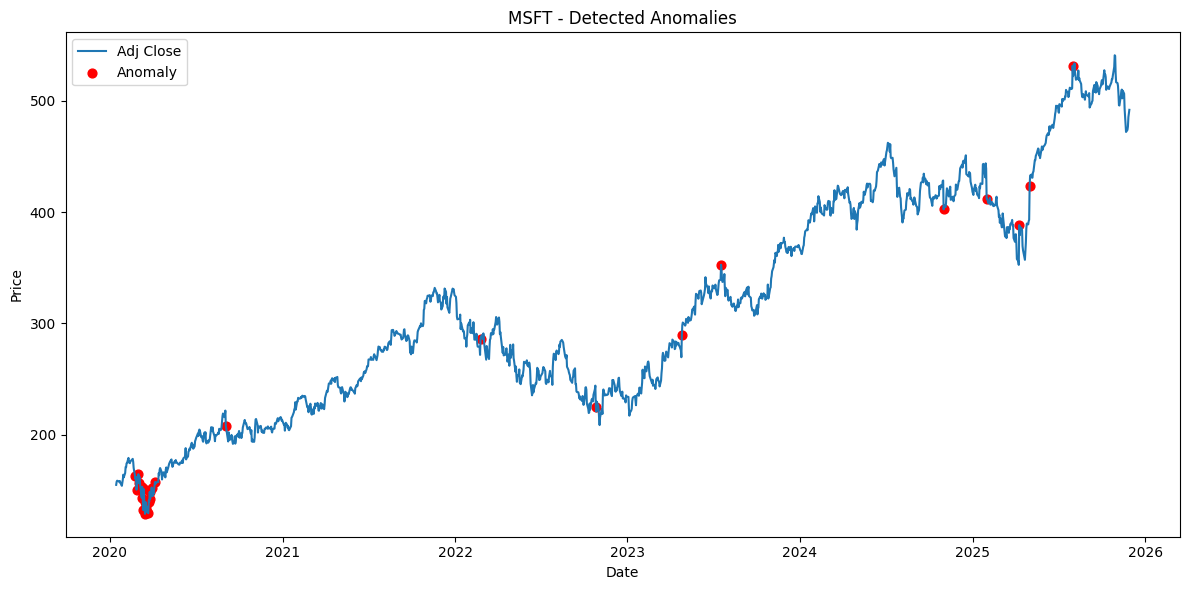


Saved anomalies to anomalies_MSFT.csv


In [12]:
print("Engineering features...")
df_feat = add_features(df_raw)

print("Scaling features...")
X = build_feature_matrix(df_feat)

print("Running Isolation Forest...")
labels, scores = detect_anomalies(X)

df_feat["is_anomaly"] = labels
df_feat["anomaly_score"] = scores

anomalies = df_feat[df_feat["is_anomaly"] == -1].sort_values("anomaly_score")

print("\nTop 10 Most Suspicious Days:")
display(anomalies[[
    "adj close",
    "return",
    "volatility_10",
    "volume_z",
    "intraday_range",
    "gap_open",
    "anomaly_score"
]].head(10))

plot_price_with_anomalies(df_feat, TICKER)

anomalies.to_csv(f"anomalies_{TICKER}.csv")
print(f"\nSaved anomalies to anomalies_{TICKER}.csv")
